In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import load_model



In [2]:

RESIZED_DIR = '/FGD/Acadamics and University/Python/Intelligent Systems/Project/MartijnTryOut/MartijnTryOut/resize2'

EMOTIONS = ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']
IMG_SIZE = 48

def load_data():
    images = []
    labels = []

    for emotion_label, emotion in enumerate(EMOTIONS):
        emotion_dir = RESIZED_DIR + '/' + emotion
        if os.path.isdir(emotion_dir):
            for img_file in os.listdir(emotion_dir):

                img_path = os.path.join(emotion_dir, img_file)
                img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                images.append(img_array)
                labels.append(emotion_label)
        else:
            print(f"Directory not found for emotion {emotion}: {emotion_dir}")

    return np.array(images), np.array(labels)


images, labels = load_data()


X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)



# Normalize the pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0



# Reshape data for CNN input
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

print(X_train.shape)
print(y_train.shape)


# Print information about the dataset
print("Number of images:", len(images))
print("Shape of images array:", images.shape)
print("Number of labels:", len(labels))




(11398, 48, 48, 1)
(11398,)
Number of images: 14248
Shape of images array: (14248, 48, 48)
Number of labels: 14248


In [3]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

In [4]:


model = models.Sequential([
    # 1st Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1), padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # 2nd Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    # 3rd Convolutional Block
    layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # 4th Convolutional Block
    layers.Conv2D(512, (3, 3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Fully Connected Layers
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.45),

    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.45),

    # Output Layer
    layers.Dense(len(EMOTIONS), activation='softmax')
])


In [5]:

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                        

In [6]:

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=50, validation_data=(X_test, y_test))


Epoch 1/50
357/357 [==============================] - 20s 26ms/step - loss: 2.0270 - accuracy: 0.2849 - val_loss: 1.5256 - val_accuracy: 0.3316
Epoch 2/50
357/357 [==============================] - 9s 24ms/step - loss: 1.5718 - accuracy: 0.3666 - val_loss: 1.6337 - val_accuracy: 0.3895
Epoch 3/50
357/357 [==============================] - 8s 23ms/step - loss: 1.3354 - accuracy: 0.4642 - val_loss: 1.1240 - val_accuracy: 0.5386
Epoch 4/50
357/357 [==============================] - 8s 23ms/step - loss: 1.1743 - accuracy: 0.5264 - val_loss: 1.2139 - val_accuracy: 0.5537
Epoch 5/50
357/357 [==============================] - 8s 23ms/step - loss: 1.0291 - accuracy: 0.5859 - val_loss: 1.2254 - val_accuracy: 0.4712
Epoch 6/50
357/357 [==============================] - 8s 24ms/step - loss: 0.9419 - accuracy: 0.6146 - val_loss: 0.8805 - val_accuracy: 0.6407
Epoch 7/50
357/357 [==============================] - 8s 23ms/step - loss: 0.8545 - accuracy: 0.6523 - val_loss: 0.8079 - val_accuracy: 0.680

In [7]:
model.save("custom2_model.keras")


90/90 - 1s - loss: 0.5846 - accuracy: 0.7919 - 877ms/epoch - 10ms/step
Test Loss: 0.5846455097198486
Test Accuracy: 0.7919298410415649


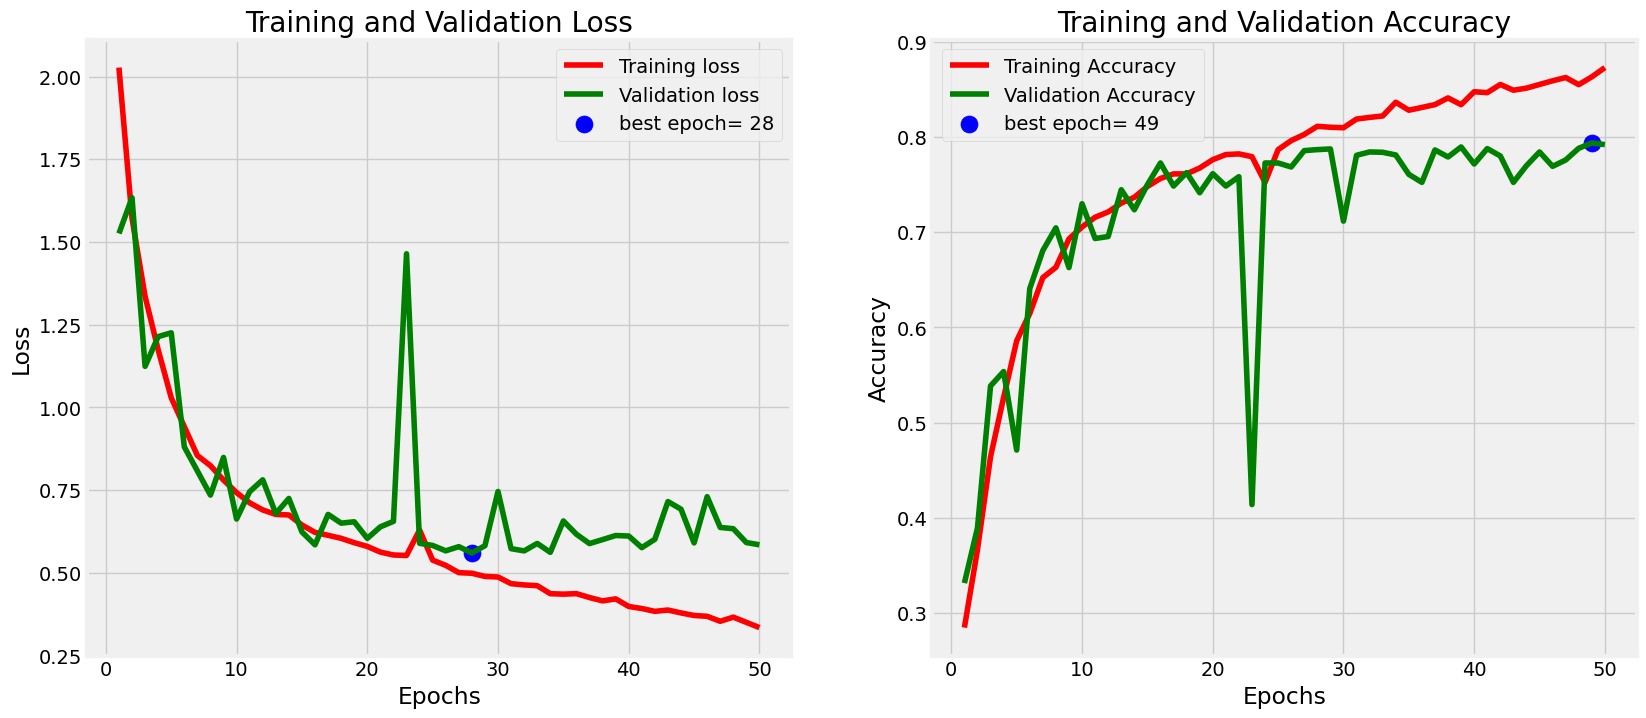

In [8]:
# model = load_model("fadimodel.h5")

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()
